In [ ]:
from fast_cleaning import fast_cleaning_longer, fast_cleaning_merge
from cleaning_old_longer import cleaning_old_longer
from cleaning_old_merge import cleaning_old_merge
from coverage_cleaning import coverage_cleaning
from validation import calc_characteristics
from matplotlib import pyplot as plt
from copy import deepcopy
from get_data import *
from time import time
import pandas as pd
import matplotlib
import os


# Create variables for analyse

In [ ]:
path = "data"
event_list = os.listdir(path)
cleaning_type_list = ["raw",
                      "cleaning_old_longer",
                      "cleaning_old_merge",
                      "fast_cleaning_longer",
                      "fast_cleaning_merge",
                      "coverage_cleaning"]

cleaning_func_list = [list,
                      cleaning_old_longer,
                      cleaning_old_merge,
                      fast_cleaning_longer,
                      fast_cleaning_merge,
                      coverage_cleaning]
plot_title = ["Efficiency",
              "Number of tracks left",
              "Fake rate",
              "Duplicates",
              "Purity"]

# Create data objects for store information

In [ ]:
event_list = [event_list[i:i + 3] for i in range(0, len(event_list), 3)]
df_efficiency = pd.DataFrame(columns=cleaning_type_list)
df_time = pd.DataFrame(columns=cleaning_type_list)
df_fake_rate = pd.DataFrame(columns=cleaning_type_list)
df_tracks_number = pd.DataFrame(columns=cleaning_type_list)
df_duplicate = pd.DataFrame(columns=cleaning_type_list)
df_purity = pd.DataFrame(columns=cleaning_type_list)

# Collect statistics of all types of cleaning

In [ ]:
for event_number, event in enumerate(event_list):
    track_file = event[0]
    hit_file = event[1]
    id_file = event[2]

    tracks = get_tracks_data(f'{path}/{track_file}', f'{path}/{hit_file}')
    hit_list = get_hits_data_for_validation(f'{path}/{hit_file}')
    track_dict = get_hits_data(f'{path}/{hit_file}')
    secon_track_list = get_secondary_track(f'{path}/{id_file}')

    print(f"###############################{event_number}/{len(event_list)}###############################")
    if not len(tracks) or not len(hit_list):
        print("ZERO")
        continue

    for cleaning_type, cleaning_func in zip(cleaning_type_list, cleaning_func_list):
        s = time()
        cleaned_tracks = cleaning_func(deepcopy(tracks))
        df_time.at[event_number, cleaning_type] = time() - s
        df_tracks_number.at[event_number, cleaning_type] = len(cleaned_tracks)
        characteristic_dict = calc_characteristics(cleaned_tracks, hit_list, track_dict, secon_track_list)

        df_efficiency.at[event_number, cleaning_type] = characteristic_dict["efficiency"]
        df_fake_rate.at[event_number, cleaning_type] = characteristic_dict["fake_rate"]
        df_duplicate.at[event_number, cleaning_type] = characteristic_dict["duplication_rate"]
        df_purity.at[event_number, cleaning_type] = characteristic_dict["purity"]

In [ ]:
# df_list = [df_efficiency, df_tracks_number, df_fake_rate, df_duplicate, df_purity, df_time]
# name_list = ["Efficiency",
#              "Number of tracks left",
#              "Fake rate",
#              "Duplicates",
#              "Purity",
#              "Time"]
# for df, name in zip(df_list, name_list):
#     df.to_csv(f"result/{name}.csv", index=False)

In [ ]:
df_efficiency = pd.read_csv(f"result/Efficiency.csv")
df_tracks_number = pd.read_csv(f"result/Number of tracks left.csv")
df_fake_rate = pd.read_csv(f"result/Fake rate.csv")
df_duplicate = pd.read_csv(f"result/Duplicates.csv")
df_purity = pd.read_csv(f"result/Purity.csv")
df_time = pd.read_csv(f"result/Time.csv")

In [ ]:
zero_index = df_efficiency[df_efficiency["raw"] < 0.1].index
df_efficiency = df_efficiency.drop(index=zero_index, axis=0)
df_tracks_number = df_tracks_number.drop(index=zero_index, axis=0)
df_fake_rate = df_fake_rate.drop(index=zero_index, axis=0)
df_duplicate = df_duplicate.drop(index=zero_index, axis=0)
df_purity = df_purity.drop(index=zero_index, axis=0)
df_time = df_time.drop(index=zero_index, axis=0)

# Drawing

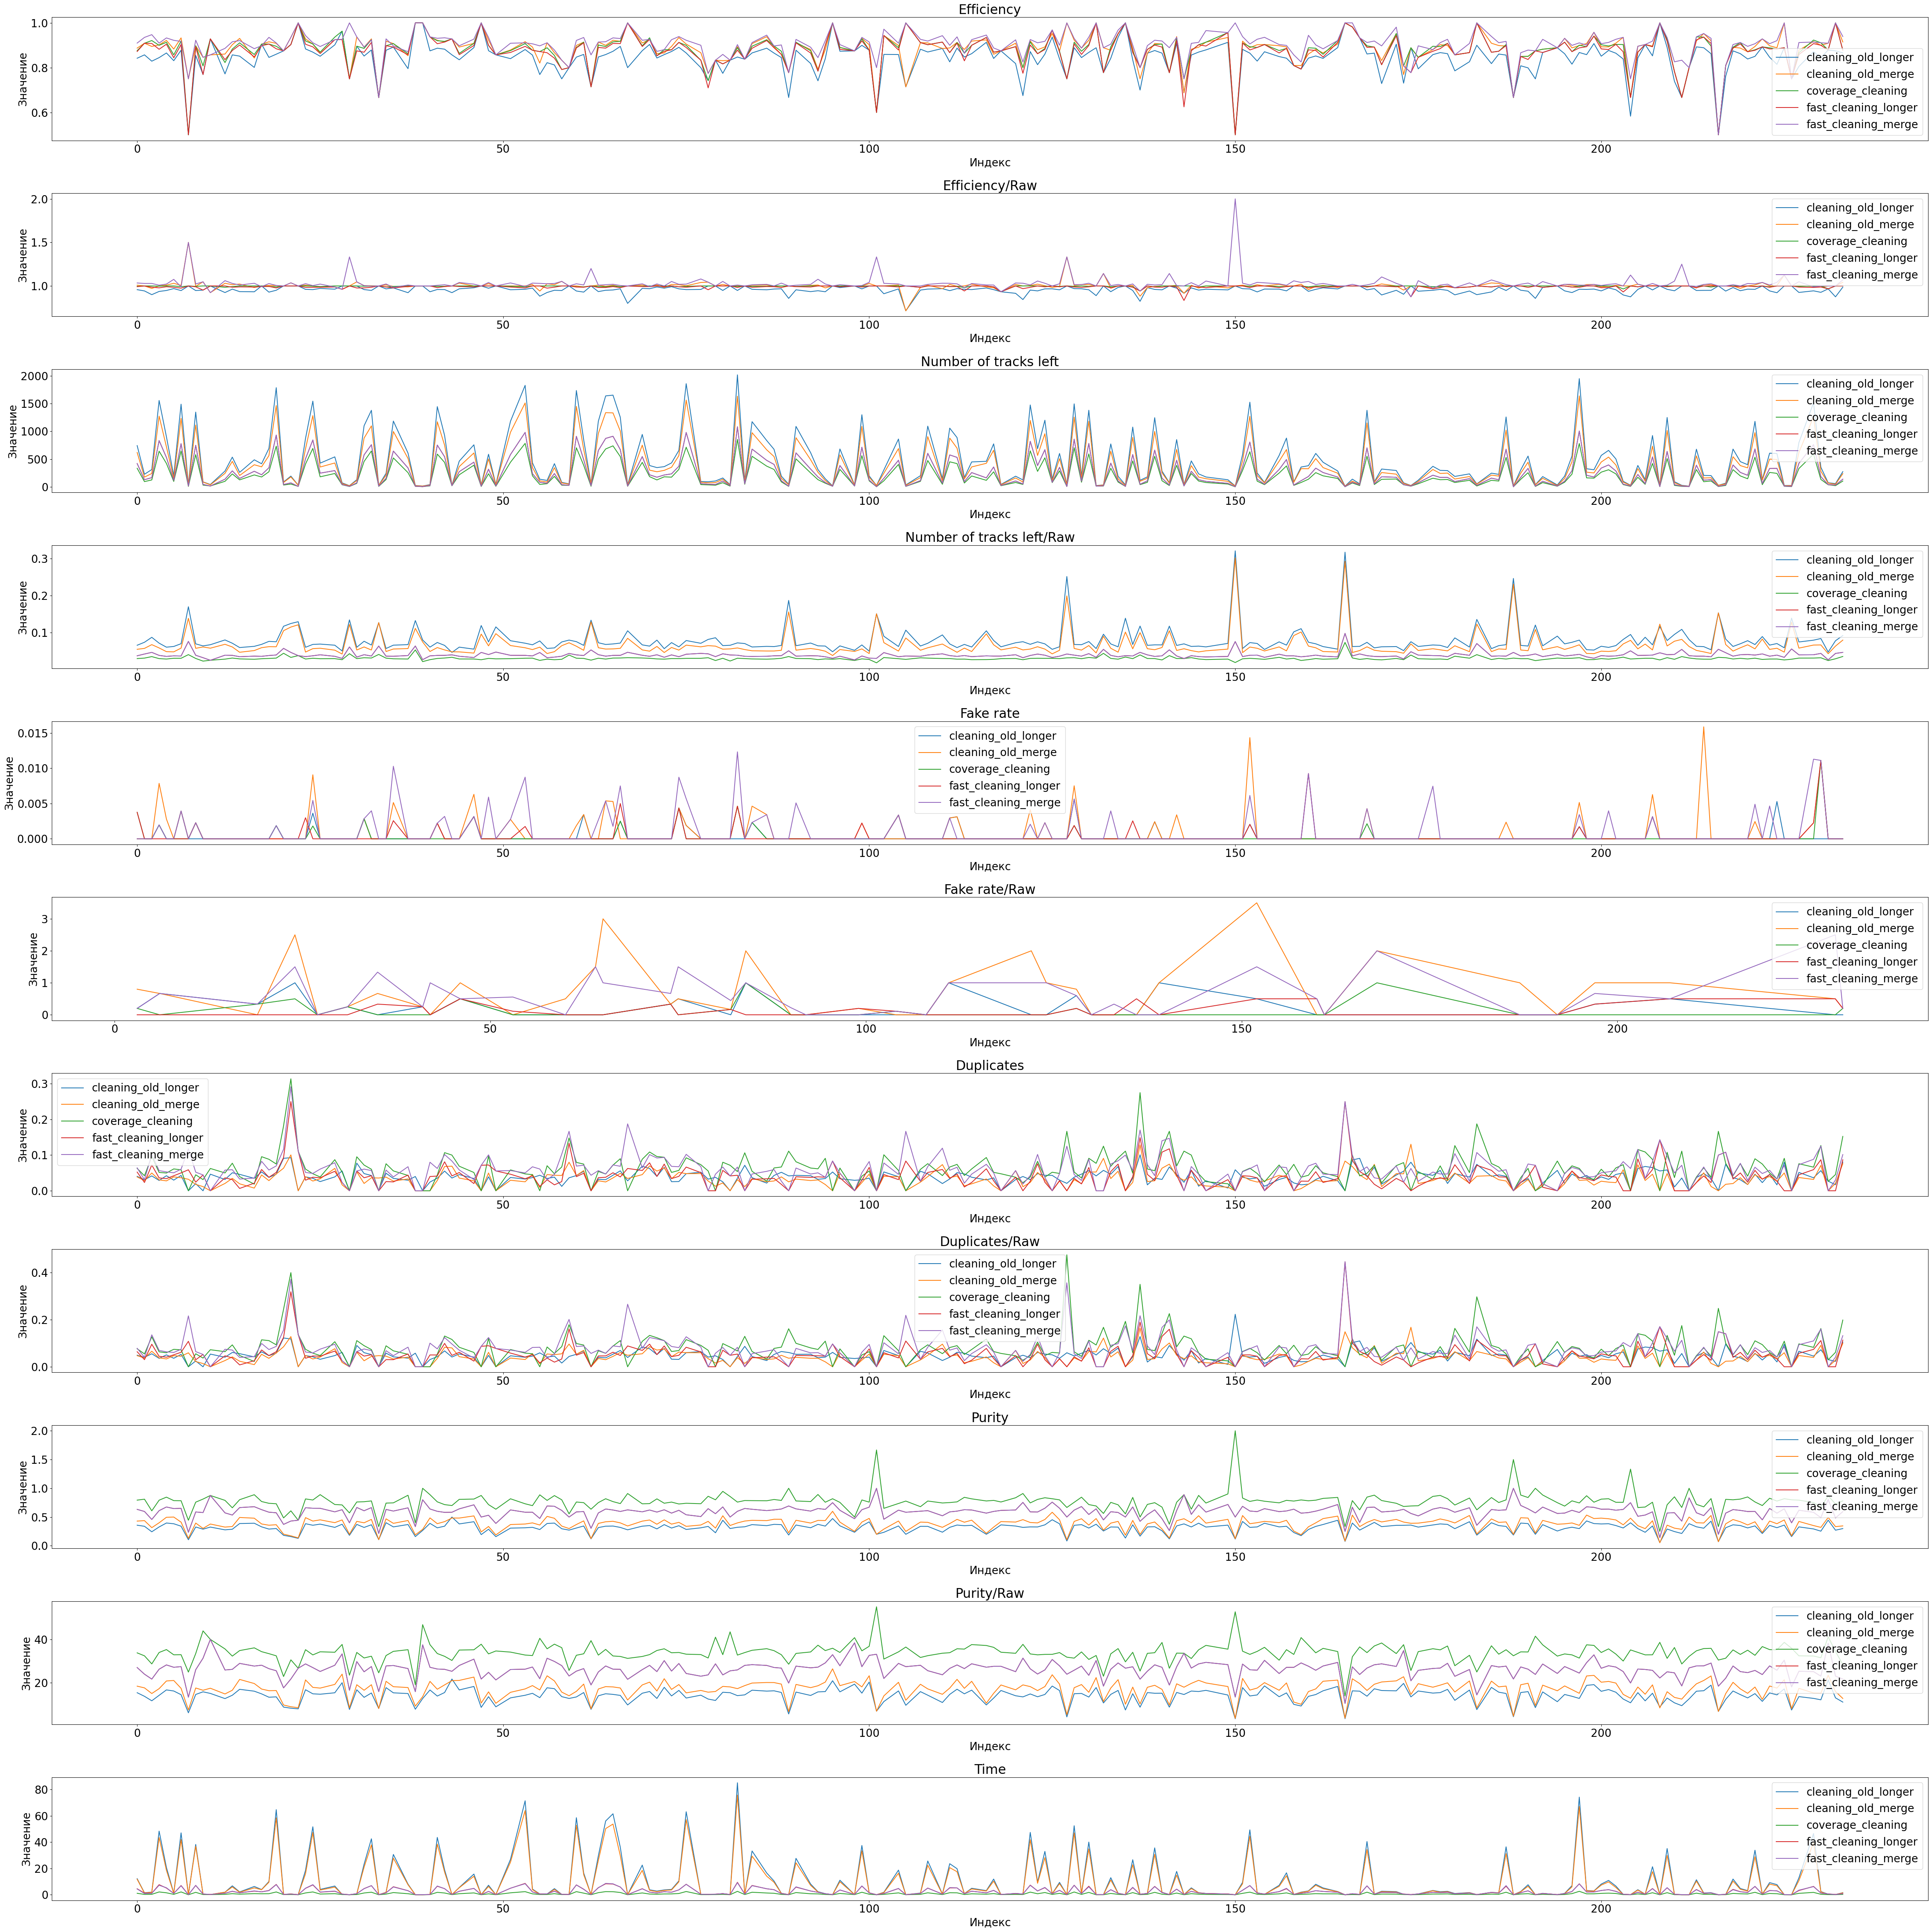

In [31]:
matplotlib.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(11, 1, figsize=(50, 50))

df_list = [df_efficiency, df_tracks_number, df_fake_rate, df_duplicate, df_purity]
for plot_id, df_id in zip(range(0, (len(df_list) + 1) * 2, 2), range(len(df_list))):
    df_normalized = df_list[df_id][df_list[df_id]["raw"] != 0]
    df_normalized = df_normalized.div(df_normalized["raw"], axis=0)

    for j, df in enumerate([df_list[df_id], df_normalized]):
        for column in df.columns.difference(["raw"]):
            axs[plot_id + j].plot(df.index, df[column], label=column)
        axs[plot_id + j].set_xlabel("Индекс")
        axs[plot_id + j].set_ylabel("Значение")
        axs[plot_id + j].set_title(plot_title[df_id] + "/Raw" if j else plot_title[df_id])
        axs[plot_id + j].legend()

for column in df_time.columns.difference(["raw"]):
    axs[len(df_list) * 2].plot(df_time.index, df_time[column], label=column)
axs[len(df_list) * 2].set_xlabel("Индекс")
axs[len(df_list) * 2].set_ylabel("Значение")
axs[len(df_list) * 2].set_title('Time')
axs[len(df_list) * 2].legend()

plt.tight_layout()
plt.show()

# Average

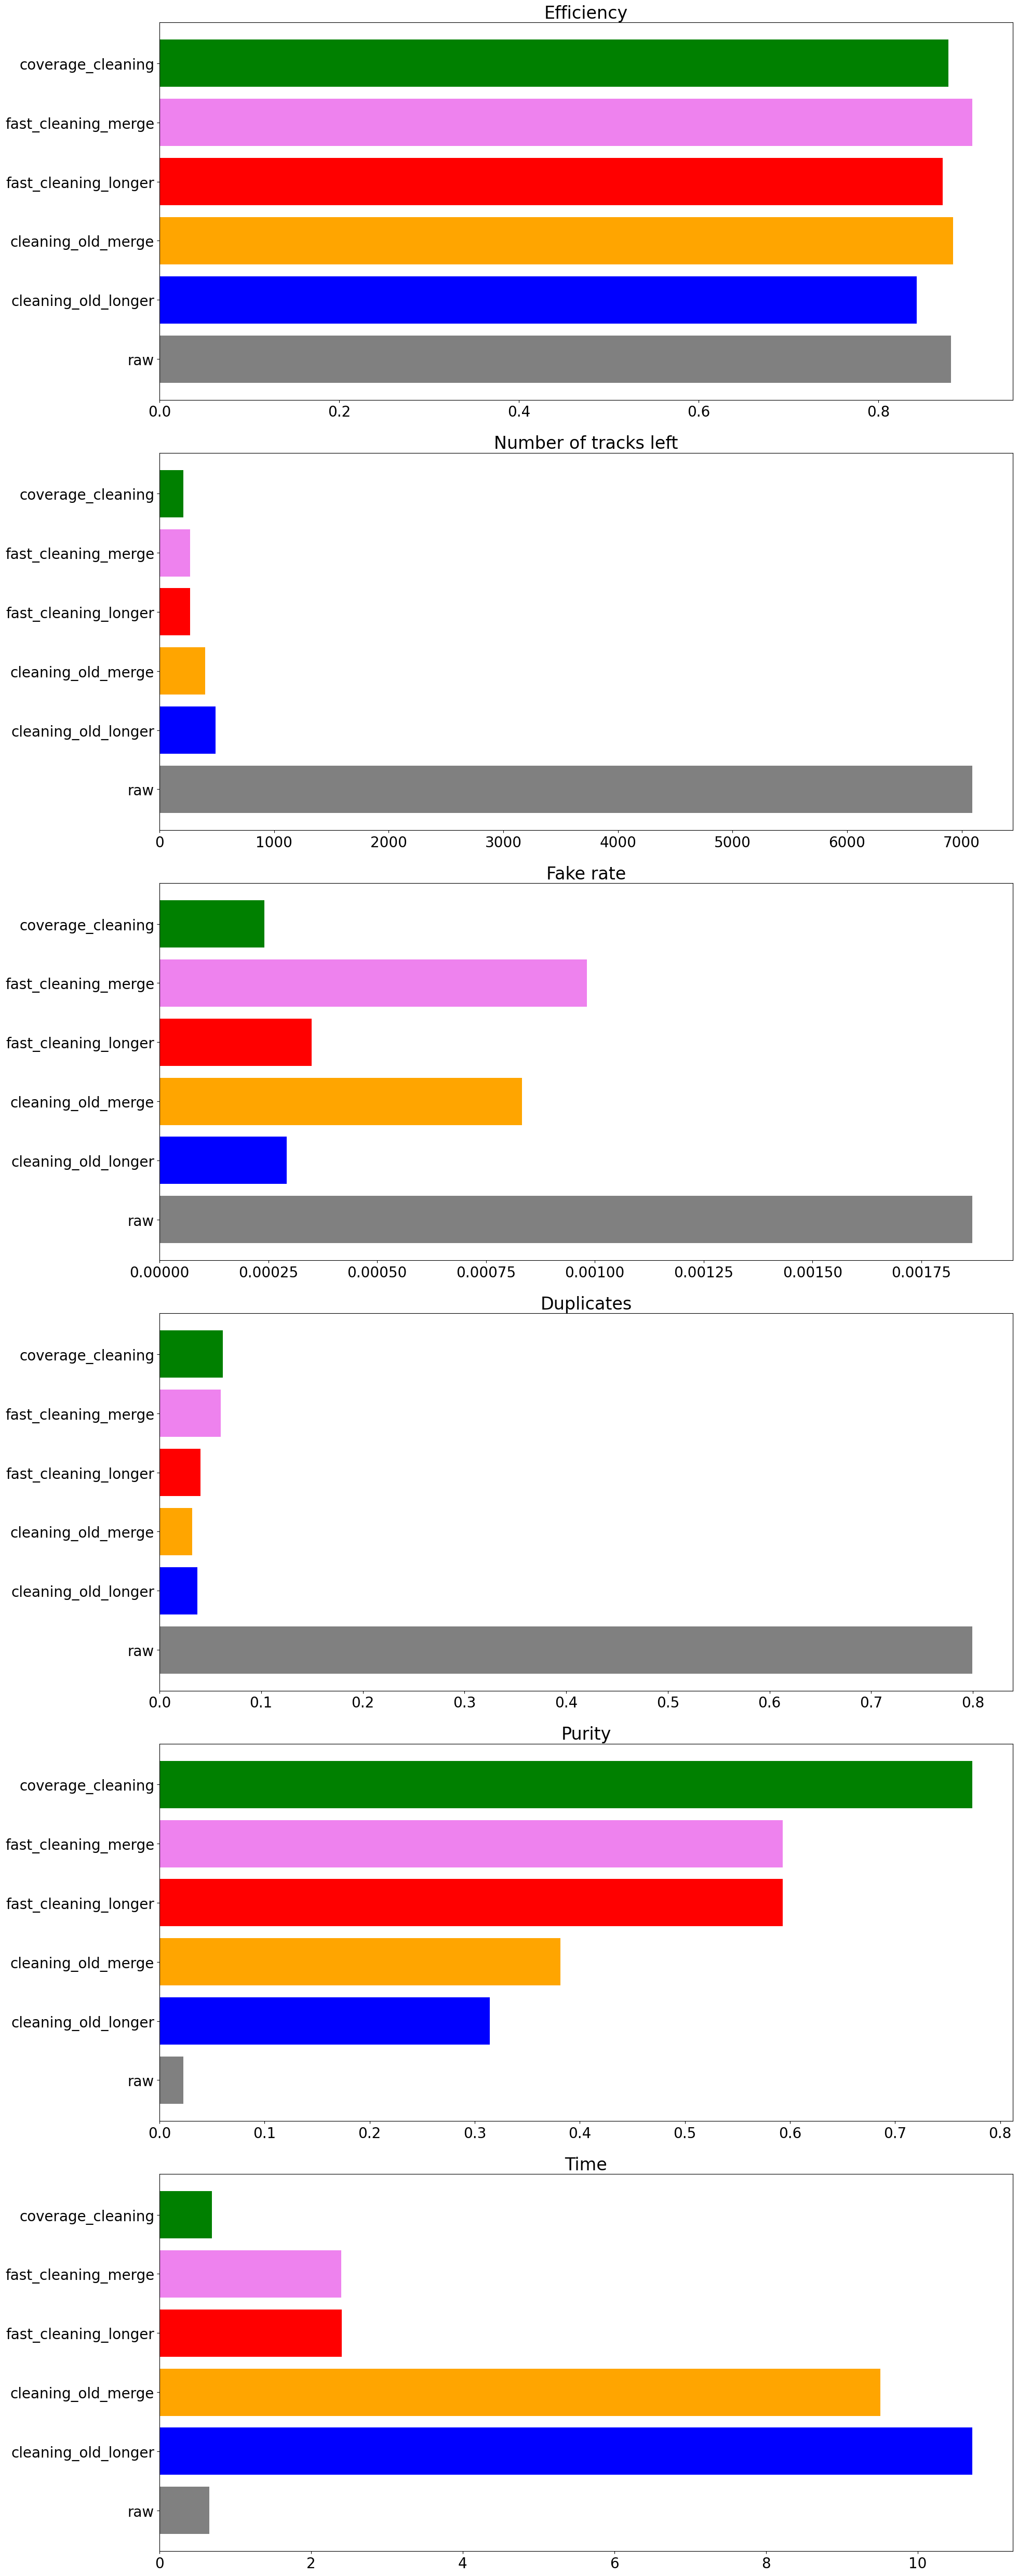

In [56]:
matplotlib.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(6, 1, figsize=(20, 50))
plot_title = ["Efficiency",
              "Number of tracks left",
              "Fake rate",
              "Duplicates",
              "Purity",
              "Time"]
colour_list = ['grey', 'blue', 'orange', 'red', 'violet', 'green']
df_list = [df_efficiency, df_tracks_number, df_fake_rate, df_duplicate, df_purity, df_time]
for plot_id, df in enumerate(df_list):
    axs[plot_id].barh(df.mean().index, df.mean().values, color=colour_list)
    axs[plot_id].set_title(plot_title[plot_id])

plt.tight_layout()
plt.show()